In [1]:
%%capture
from scipy.optimize import minimize 
%run EOMs.ipynb
%matplotlib inline

- Confirmed numerically the definitions of the separatrix, $k$, $k_{crit}$, and $H_{sep}$
- For this section, need to run Preamble, EOMs above, and Symbols & expressions below

# Symbols & expressions

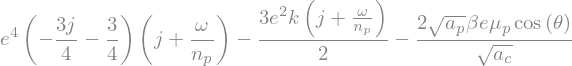

In [2]:
ac = symbols("a_c",positive=True)
H_simp_expr = (
    -Rational(3, 4) * (j + 1) * (j + om / np) * e**4
    - Rational(3, 2) * k * (j + om / np) * e**2
    - 2 * b * sqrt(ap / ac) * mup * e * cos(th)
)
H_simp_expr

In [3]:
H_simp_expr.free_symbols

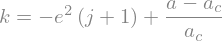

In [4]:
k_expr = (a-ac)/ac - (j+1)*e**2
Eq(k,k_expr)

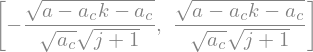

In [5]:
solve(Eq(k,k_expr),e)

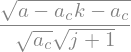

In [6]:
e_expr_a_k = solve(Eq(k,k_expr),e)[1]
e_expr_a_k

# Single capture run

## Integrate

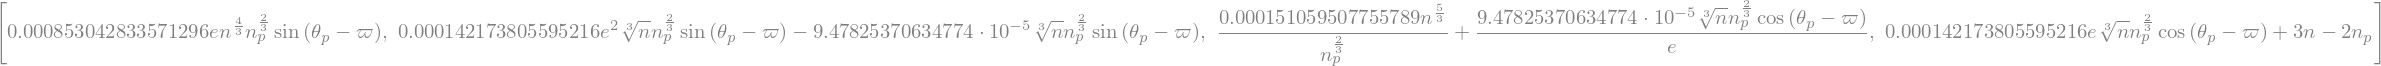

In [7]:
TMVAL = 2 * npy.pi * 1e6
convs = {}
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
    ep: 0.0
}

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
params[omp] = 0
params[om] = params[omp] * alpha0val**3.5


funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
]
funs

In [8]:
xp = [n, e, pom, thp, np, t]

In [9]:
T_TURNOFF = 2.5e5
funcl = lambdify(xp, funs)
def func(t, x0):
    if t < T_TURNOFF: 
        npval = npy.exp(-t/TMVAL)
    else:
        npval = npy.exp(-T_TURNOFF/TMVAL)
    return funcl(*x0, npval, t)

In [10]:
teval = npy.linspace(0, 2 * npy.pi * 0.5e5, 10000)
sol = sp.integrate.solve_ivp(
    func,
    [teval[0], teval[-1]],
    [1/1.55, 0.001, 1, 2],
    t_eval=teval,
    rtol=1e-9,
    #atol=1e-9,
    method="DOP853",
)

In [11]:
a_vals = sol.y[0, :] ** (-2.0 / 3)
np_vals = npy.exp(-sol.t / TMVAL)
np_vals[npy.where(sol.t > T_TURNOFF)] = npy.exp(-T_TURNOFF / TMVAL)

ap_vals = np_vals ** (-2.0 / 3)
nc_vals = (params[om] + params[j] * np_vals) / (params[j] + 1)
ac_vals = nc_vals ** (-2.0 / 3)
e_vals = sol.y[1, :]
th_vals = (sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]) % (2 * npy.pi)
k_vals = (a_vals - ac_vals) / ac_vals - (params[j] + 1) * e_vals**2
k_crit = -(
    (3 * (params[j] + 1) * ap_vals * params[b] ** 2 / (params[j] ** 2 * ac_vals))
    ** (1.0 / 3)
) * params[mup] ** (2.0 / 3)

H_vals = (
    -0.75 * (params[j] + 1) * (params[j] + params[om] / np_vals) * e_vals**4
    - 1.5 * k_vals * (params[j] + params[om] / np_vals) * e_vals**2
    - 2
    * params[b]
    * npy.sqrt(ap_vals / ac_vals)
    * params[mup]
    * e_vals
    * npy.cos(th_vals)
)

## Evolution plot

<Figure size 640x480 with 0 Axes>

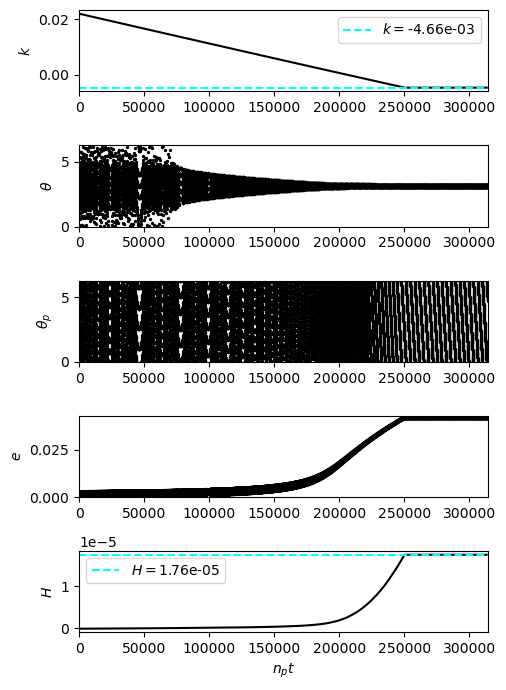

In [12]:
plt.clf()
plt.figure(figsize=(5, 7))

plt.subplot(5, 1, 1)
plt.ylabel(r"$k$")
plt.plot(sol.t, k_vals, c="k")
plt.axhline(y=k_vals[-1], c="cyan", ls="--", label=r"$k=$"+f"{k_vals[-1]:0.2e}")
plt.legend()

plt.subplot(5, 1, 2)
plt.ylabel(r"$\theta$")
plt.ylim(0, 2 * npy.pi)
plt.scatter(
    sol.t, (sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]) % (2 * npy.pi), c="k", s=2
)

plt.subplot(5, 1, 3)
plt.ylabel(r"$\theta_p$")
plt.ylim(0, 2 * npy.pi)
plt.scatter(sol.t, sol.y[3, :] % (2 * npy.pi), c="k", s=2)

plt.subplot(5, 1, 4)
plt.ylabel(r"$e$")
plt.plot(sol.t, sol.y[1, :], c="k")
plt.ylim((0,npy.max(sol.y[1,:])))

plt.subplot(5, 1, 5)
plt.ylabel(r"$H$")
plt.plot(sol.t, H_vals, c="k")
plt.axhline(y=H_vals[-1], c="cyan", ls="--", label=r"$H=$"+f"{H_vals[-1]:0.2e}")
plt.legend()
plt.xlabel(r"$n_p t$")
plt.tight_layout()
for _ in plt.gcf().axes:
    _.set_xlim(sol.t[0], sol.t[-1])
save_to_clipboard()

## Hamiltonian Level Curve Plotting at a certain time index

In [13]:
snap_index = -1

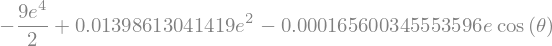

In [14]:
H_simp_expr_plugin = H_simp_expr.subs(
    {
        ac: ac_vals[snap_index],
        ap: ap_vals[snap_index],
        b: params[b],
        j: params[j],
        k: k_vals[snap_index],
        mup: params[mup],
        om: params[om],
    }
)
H_simp_expr_plugin

In [15]:
e_grid, th_grid = npy.meshgrid(npy.linspace(0.001,0.1,1000), npy.pi+npy.linspace(-npy.pi,npy.pi,1000))
H_func = lambdify([th,e],H_simp_expr_plugin)

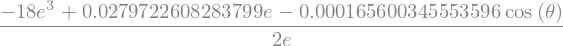

In [16]:
thdot = H_simp_expr_plugin.diff(e)/(2*e)
thdot

In [17]:
# Hamiltonian level curve on x-axis
#plt.clf()
#plt.plot(-e_grid[0,:],(lambda x: lambdify([th,e],thdot*e)(npy.pi,x))(e_grid[0,:]))
#plt.plot(e_grid[0,:],(lambda x: lambdify([th,e],thdot*e)(0,x))(e_grid[0,:]))
#plt.show()

In [18]:
root0 = brentq((lambda x: lambdify([th,e],thdot*e)(npy.pi,x)), 0.001,0.1)
root1 = brentq((lambda x: lambdify([th,e],thdot*e)(0,x)), 0.005,0.02)
root2 = brentq((lambda x: lambdify([th,e],thdot*e)(0,x)), 0.02,0.1)

In [19]:
root2

In [20]:
# Value of k
display(k_vals[snap_index])
# Value of H for separatrix at this k
H_sep_val = H_simp_expr_plugin.subs({th:0,e:root2})
display(H_sep_val)
# Current value of H
display(H_vals[snap_index])

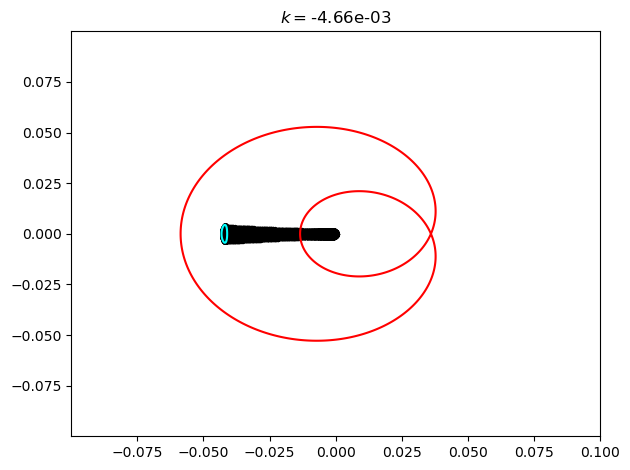

In [21]:
plt.clf()
T_PLOT = 0
ind_plot = npy.where(sol.t > T_PLOT)
e_vals = sol.y[1, :][ind_plot]
th_vals = (
    sol.y[3, :][ind_plot] + params[omp] * sol.t[ind_plot] - sol.y[2, :][ind_plot]
) % (2 * npy.pi)
plt.title(r"$k=$"+f"{k_vals[snap_index]:0.2e}")
plt.scatter(e_vals * npy.cos(th_vals), e_vals * npy.sin(th_vals), s=2, c="k")
plt.contour(
    e_grid * npy.cos(th_grid),
    e_grid * npy.sin(th_grid),
    H_func(th_grid, e_grid),
    levels=sorted([H_vals[snap_index],H_sep_val]),
    colors=["red","cyan"],
    #linestyles=["--","--"],
)
# plt.colorbar()
plt.tight_layout()
plt.show()

In [22]:
# e as a function of k and a
e_func = lambdify(e,e_expr_a_k.subs({ac:ac_vals[snap_index],j:params[j],k:k_vals[snap_index]}))
e_func

<function _lambdifygenerated(e)>

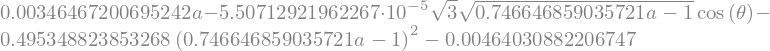

In [23]:
# H(a,th;k)
H_a_th = H_simp_expr_plugin.subs({e:e_expr_a_k}).subs({ac:ac_vals[snap_index],j:params[j],k:k_vals[snap_index]})
H_a_th_func = lambdify([th,a],H_a_th)
display(H_a_th)

In [24]:
a_grid, th_a_grid = npy.meshgrid(npy.linspace(1.33,1.36,1000),npy.linspace(0,2*npy.pi,1000))

<lambdifygenerated-37>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.00346467200695242*a - 5.50712921962267e-5*sqrt(3)*sqrt(0.746646859035721*a - 1)*cos(theta) - 0.495348823853268*(0.746646859035721*a - 1)**2 - 0.00464030882206747
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

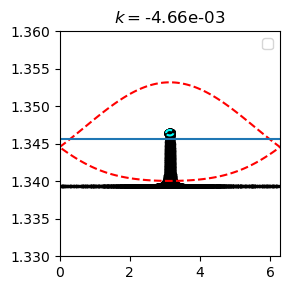

<Figure size 640x480 with 0 Axes>

In [25]:
T_PLOT = 3e5
plt.clf()
plt.figure(figsize=(3,3))
a_vals = (sol.y[0, :][ind_plot])**(-2./3)
th_vals = (
    sol.y[3, :][ind_plot] + params[omp] * sol.t[ind_plot] - sol.y[2, :][ind_plot]
) % (2 * npy.pi)
plt.scatter(th_vals,a_vals, s=2, c="k")
levels = [H_sep_val,H_vals[snap_index]]
#levels = npy.linspace(float(H_sep_val),H_vals[snap_index],10)
cs = plt.contour(
    th_a_grid,
    a_grid,
    H_a_th_func(th_a_grid, a_grid),
    levels=levels,
    colors=["red","cyan"],
    linestyles=["--","--"],
)
labels=[r"$H=H_{\rm sep}$"+f"{H_sep_val}",r"$H=$"+f"{H_vals[snap_index]}"]
plt.title(r"$k=$"+f"{k_vals[snap_index]:0.2e}")
plt.axhline(y=ac_vals[snap_index])
# plt.colorbar()
plt.legend()
plt.tight_layout()
plt.show()
save_to_clipboard()

# Single run hand placed

In [26]:
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
    ep: 0.0
}

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
params[omp] = 0
params[om] = params[omp] * alpha0val**3.5

In [27]:

ap_sel =1.026880764932741 #ap_vals[-1]
print(ap_sel)
ac_sel = 1.34559446378806 #ac_vals[-1]
print(ac_sel)
k_sel = -0.004662043471396658#k_vals[-1]
print(k_sel)
np_sel =0.9609924410332833 #np_vals[-1]
print(np_sel)
pomp_sel = 0 #params[omp]*sol.t[-1]
print(pomp_sel)

1.026880764932741
1.34559446378806
-0.004662043471396658
0.9609924410332833
0


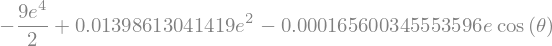

In [28]:
H_e_th_sel = H_simp_expr.subs({
    j: params[j],
    om: params[om],
    mup: params[mup],
    ap: ap_sel,
    k: k_sel,
    b: params[b],
    ac: ac_sel,
})
H_e_th_sel_func = lambdify([th,e],H_e_th_sel)
H_e_th_sel


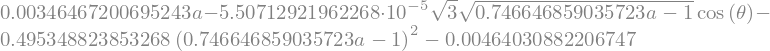

In [29]:
H_a_th_sel = H_simp_expr.subs({e:e_expr_a_k}).subs({
    j: params[j],
    om: params[om],
    mup: params[mup],
    ap: ap_sel,
    k: k_sel,
    b: params[b],
    ac: ac_sel,
})
H_a_th_sel_func = lambdify([th,a],H_a_th_sel)
H_a_th_sel

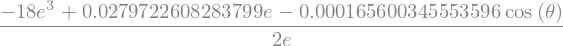

In [30]:

thdot_sel = H_e_th_sel.diff(e)/(2*e)
thdot_sel


In [31]:

root0 = brentq((lambda x: lambdify([th,e],thdot_sel*e)(npy.pi,x)), 0.001,0.1)
root1 = brentq((lambda x: lambdify([th,e],thdot_sel*e)(0,x)), 0.005,0.02)
root2 = brentq((lambda x: lambdify([th,e],thdot_sel*e)(0,x)), 0.02,0.1)

In [32]:
print(root0)
print(root1)
print(root2)

0.04210147957764366
0.006063626875062423
0.036037852702773085


In [33]:
# Value of H for separatrix at this k
H_sep_val = H_e_th_sel.subs({th:0,e:root2})
display(H_sep_val)

In [34]:
H_val_sel = 5e-6
th_sel = npy.pi+1

In [35]:
H_val_sel

In [36]:
e_grid, th_grid = npy.meshgrid(npy.linspace(0.001,0.1,1000), npy.pi+npy.linspace(-npy.pi,npy.pi,1000))

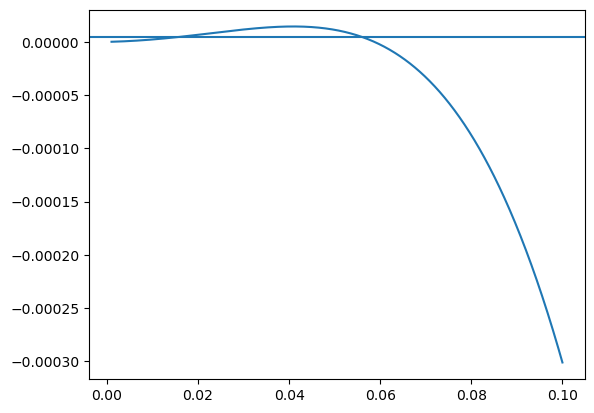

In [37]:
plt.clf()
#plt.plot(-e_grid[0,:],H_e_th_sel_func(npy.pi,e_grid[0,:]))
#plt.plot(e_grid[0,:],H_e_th_sel_func(0,e_grid[0,:]))
plt.plot(e_grid[0,:],H_e_th_sel_func(th_sel,e_grid[0,:]))
plt.axhline(y=H_val_sel)
plt.show()

In [38]:
_ = lambda x: H_e_th_sel_func(th_sel,x)-H_val_sel
e0_sel = brentq(_,0.045,0.06)
e0_sel

In [39]:
a0_sel =solve(Eq(k_sel,k_expr.subs({e:e0_sel,ac:ac_sel,j:params[j]})), a)[0]
a0_sel

In [40]:
pom0_sel = 1

In [41]:
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
xp = [n, e, pom, thp, np, t]
T_TURNOFF = 0
funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
]
funs
funcl = lambdify(xp, funs)
def func(t, x0):
    return funcl(*x0, np_sel, t)
teval = npy.linspace(0, 2 * npy.pi * 1e4, 10000)
sol = sp.integrate.solve_ivp(
    func,
    [teval[0], teval[-1]],
    [a0_sel**(-3./2), e0_sel, pom0_sel, th_sel-pom0_sel+pomp_sel],
    t_eval=teval,
    rtol=1e-9,
    #atol=1e-9,
    method="DOP853",
)

In [42]:
a_vals = sol.y[0, :] ** (-2.0 / 3)

ap_vals = np_sel ** (-2.0 / 3)
nc_vals = (params[om] + params[j] * np_sel) / (params[j] + 1)
ac_vals = nc_vals ** (-2.0 / 3)
e_vals = sol.y[1, :]
th_vals = (sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]) % (2 * npy.pi)
k_vals = (a_vals - ac_vals) / ac_vals - (params[j] + 1) * e_vals**2
k_crit = -(
    (3 * (params[j] + 1) * ap_vals * params[b] ** 2 / (params[j] ** 2 * ac_vals))
    ** (1.0 / 3)
) * params[mup] ** (2.0 / 3)

H_vals = (
    -0.75 * (params[j] + 1) * (params[j] + params[om] / np_sel) * e_vals**4
    - 1.5 * k_vals * (params[j] + params[om] / np_sel) * e_vals**2
    - 2
    * params[b]
    * npy.sqrt(ap_vals / ac_vals)
    * params[mup]
    * e_vals
    * npy.cos(th_vals)
)

In [43]:
#plt.clf()
#plt.plot(sol.t,H_vals)
#plt.show()

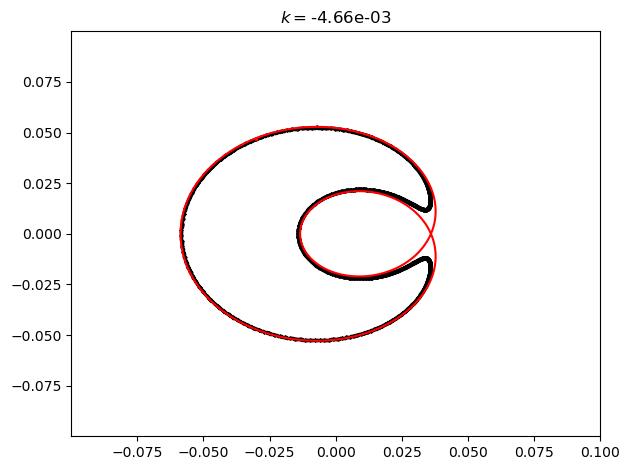

In [44]:
plt.clf()
e_vals = sol.y[1, :]
th_vals = (
    sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]
) % (2 * npy.pi)
plt.title(r"$k=$"+f"{k_sel:0.2e}")
plt.scatter(e_vals * npy.cos(th_vals), e_vals * npy.sin(th_vals), s=2, c="k")
plt.scatter(e_vals[0] * npy.cos(th_vals[0]), e_vals[0] * npy.sin(th_vals[0]), s=2, c="r")
plt.contour(
    e_grid * npy.cos(th_grid),
    e_grid * npy.sin(th_grid),
    H_e_th_sel_func(th_grid, e_grid),
    levels=sorted([H_sep_val]),
    colors=["red","cyan"],
    #linestyles=["--","--"],
)
# plt.colorbar()
plt.tight_layout()
plt.show()

In [45]:
a_grid, th_a_grid = npy.meshgrid(npy.linspace(1.33,1.36,1000),npy.linspace(0,2*npy.pi,1000))

<lambdifygenerated-39>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.00346467200695243*a - 5.50712921962268e-5*sqrt(3)*sqrt(0.746646859035723*a - 1)*cos(theta) - 0.495348823853268*(0.746646859035723*a - 1)**2 - 0.00464030882206747
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

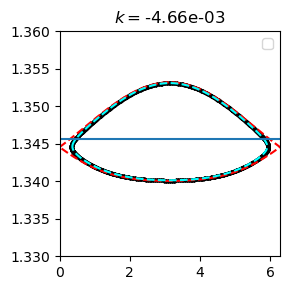

<Figure size 640x480 with 0 Axes>

In [46]:
plt.clf()
plt.figure(figsize=(3,3))
a_vals = (sol.y[0, :])**(-2./3)
th_vals = (
    sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]
) % (2 * npy.pi)
plt.scatter(th_vals,a_vals, s=2, c="k")
levels = [H_sep_val,H_val_sel]
#levels = npy.linspace(float(H_sep_val),H_vals[snap_index],10)
cs = plt.contour(
    th_a_grid,
    a_grid,
    H_a_th_sel_func(th_a_grid, a_grid),
    levels=levels,
    colors=["red","cyan"],
    linestyles=["--","--"],
)
labels=[r"$H=H_{\rm sep}$"+f"{H_sep_val}",r"$H=$"+f"{H_val_sel}"]
plt.title(r"$k=$"+f"{k_sel:0.2e}")
plt.axhline(y=ac_sel)
# plt.colorbar()
plt.legend()
plt.tight_layout()
plt.show()
save_to_clipboard()

# Separatrix at k_crit for $\theta$ vs $\theta_p$ with $\omega$, $\omega_p$

In [47]:
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
    ep: 0.0
}
alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
params[omp] = 0.0
params[om] = 0#params[omp] * alpha0val**3.5

In [48]:
np_sel = 1
ap_sel = np_sel**(-2./3)
nc_sel = (params[j]*np_sel + params[om])/(params[j]+1)
ac_sel = nc_sel**(-2./3)
pomp_sel = 0
print(np_sel)
print(ap_sel)
print(nc_sel)
print(ac_sel)

1
1.0
0.6666666666666666
1.3103706971044484


In [49]:
k_sel = -(
    (3 * (params[j] + 1) * ap_sel * params[b] ** 2 / (params[j] ** 2 * ac_sel))
    ** (1.0 / 3)
) * params[mup] ** (2.0 / 3)
k_sel

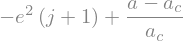

In [50]:
k_expr

In [51]:
k_sel = 1.*k_sel
k_sel

In [52]:
#k_sel = -1

- okay why do these have different numerical values?? 
- its negative & i put in -ap_sel bc its under a cubed root
  - had ap_sel in denom of cubed root instead of ac_sel

In [53]:
-solve(discriminant(term_multiply(H_simp_expr.subs({om:0}).diff(e),e)),k)[0].subs({j:params[j],th:0,b:params[b],mup:params[mup],ap:-ap_sel,ac:ac_sel}).evalf()

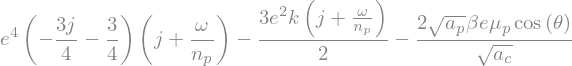

In [54]:
H_simp_expr

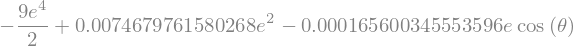

In [55]:
H_e_th_sel = H_simp_expr.subs({
    j: params[j],
    om: params[om],
    mup: params[mup],
    ap: ap_sel,
    k: k_sel,
    b: params[b],
    ac: ac_sel,
    np:np_sel
})
H_e_th_sel_func = lambdify([th,e],H_e_th_sel)
H_e_th_sel

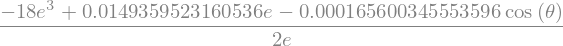

In [56]:
thdot_sel = H_e_th_sel.diff(e)/(2*e)
thdot_sel

In [57]:
#plt.clf()
#e_dom = npy.linspace(0.,0.1,1000)
#_ = lambda x: lambdify([th,e],thdot_sel*e)(0,x)
#plt.plot(e_dom, [_(x) for x in e_dom])
#plt.axhline(y=0,c="k")
#plt.show()

In [58]:
#e_search = npy.linspace(0.0,1,10000)
#_ = lambda x: -lambdify([th,e],thdot_sel*e)(0,x)
#roots = []
#for i in range(len(e_search)-1):
#    #root = minimize(_,0.05,bounds=[(0,.1)]).x[0]
#    try:
#        root = brentq(_,e_search[i],e_search[i+1])
#        roots += [root]
#    except ValueError:
#        pass
#root = max(roots)

In [59]:
_ = lambda x: -lambdify([th, e], thdot_sel*e)(0,x)
root = minimize(_,0.05,bounds=[(0,.1)]).x[0]
root

In [60]:
H_sep_val_sel = H_e_th_sel.subs({e:root,k:k_sel,th:0})
H_sep_val_sel

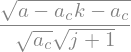

In [61]:
e_expr_a_k

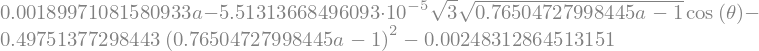

In [62]:
H_a_th_sel = H_simp_expr.subs({e:e_expr_a_k}).subs({
    j: params[j],
    om: params[om],
    mup: params[mup],
    ap: ap_sel,
    k: k_sel,
    b: params[b],
    ac: ac_sel,
    np:np_sel
})
H_a_th_sel_func = lambdify([th,a],H_a_th_sel)
H_a_th_sel

- The separatrix value is correct in e-th space.

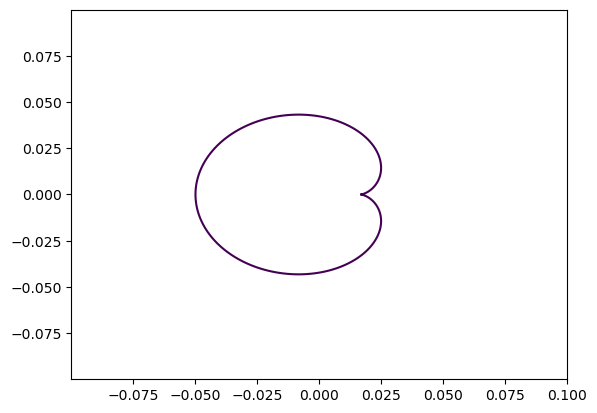

In [63]:
th_dom, e_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000),npy.linspace(0,0.1,1000))
plt.clf()
cs = plt.contour(npy.cos(th_dom)*e_dom,npy.sin(th_dom)*e_dom,H_e_th_sel_func(th_dom,e_dom),levels=[H_sep_val_sel]) #,levels=(1+npy.linspace(2,-10,10))*H_sep_val_sel)
#plt.clabel(cs, inline=True, fmt="%0.3e")
plt.show()

- it's just a line in a-th space
- Why are there no contours under?

<lambdifygenerated-91>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.00189971081580933*a - 5.51313668496093e-5*sqrt(3)*sqrt(0.76504727998445*a - 1)*cos(theta) - 0.49751377298443*(0.76504727998445*a - 1)**2 - 0.00248312864513151


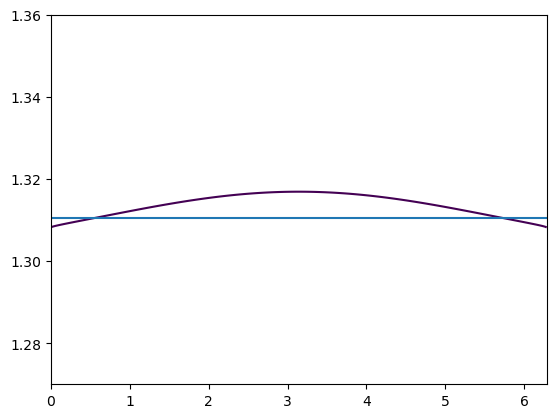

In [64]:
th_dom, a_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000),npy.linspace(1.27,1.36,1000))
plt.clf()
#cs = plt.contour(th_dom,a_dom,H_a_th_sel_func(th_dom,a_dom),levels=sorted([H_sep_val_sel]+[x for x in npy.linspace(-4e-5,4e-5,50)])) #,levels=(1+npy.linspace(2,-10,10))*H_sep_val_sel)
cs = plt.contour(th_dom,a_dom,H_a_th_sel_func(th_dom,a_dom),levels=[H_sep_val_sel])
#plt.clabel(cs, inline=True, fmt="%0.3e")
#cs = plt.pcolormesh(th_dom,a_dom,H_a_th_sel_func(th_dom,a_dom))
plt.axhline(y=ac_sel)
plt.show()

# Params

In [1115]:
convs = {}
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 0,  # 12.08476062046314,
    b2_3_2: 0,  # 10.485706741948807,
    ep: 0.03,
}
alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
N_runs = 8
varpip0val = 0 
pom0val = npy.pi
a0vals = npy.linspace(1.26, 1.303, N_runs)
#th0vals = npy.ones(N_runs)*0
# a0vals, th0vals = npy.random.uniform(1.29, 1.33, N_runs), npy.random.uniform(0, 2 * npy.pi, N_runs)
#a0vals = npy.random.uniform(1.25, 1.33, N_runs)
#th0vals = npy.random.uniform(0,2*npy.pi, N_runs)

In [1116]:
k_sel = -0.1
T_INTEG = 5e4
params[omp] =1.1e-1
params[om]  = 1e-2 #params[omp] * alpha0val**3.5
print(params[omp]-params[om])

0.1


In [1117]:
th0vals = npy.zeros(len(a0vals)) + npy.pi

# $\theta_p$ separatrix

In [1118]:
thp_dot = symbols(r"\dot{\theta_p}")
thp_dot

In [1119]:
thp_dot_expr = (j+1)*n-j*np - omp
thp_dot_expr

In [1120]:
ncp = symbols(r"n_{c\,p}")
ncp

In [1121]:
nup = symbols(r"\nu_{p}")
nup

In [1122]:
acp = symbols(r"a_{c\,p}")
acp

In [1123]:
np_sel = 1
ncp_sel = np_sel*((params[j])/(params[j]+1) + params[omp]/np_sel/(params[j]+1))
print(ncp_sel)
ap_sel = np_sel**(-2./3)
print(ap_sel)
acp_sel = ncp_sel**(-2./3)
print(acp_sel)

0.7033333333333333
1.0
1.2644234246103594


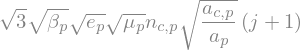

In [1124]:
nup_expr = ncp*(3*bp/ap*acp)**Rational(1,2)*(j+1)*sqrt(mup*ep)
nup_expr

In [1125]:
H_p_simp_expr = Rational(1,2)*thp_dot**2 - nup**2*cos(thp)

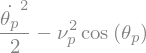

In [1126]:
H_p_simp_expr

- $\dot\theta_p$ is the canonical conjugate momentum to $\theta_p$

In [1127]:
-H_p_simp_expr.diff(thp)

In [1128]:
H_p_simp_expr.diff(thp_dot)

In [1129]:
H_p_simp_expr.diff(thp)

- fixed points at $\theta_p=0,\pi$, $\dot\theta_p=0$

In [1130]:
params[ep]

In [1131]:
H_p_sep_val_sel = H_p_simp_expr.subs({thp_dot:0,thp:npy.pi}).subs({nup:nup_expr}).subs({
    j:params[j],
    bp:params[bp],
    acp:acp_sel,
    ep:params[ep],
    mup:params[mup],
    ncp:ncp_sel,
    ap:ap_sel,
})
H_p_sep_val_sel 

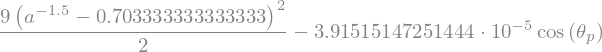

In [1132]:
H_p_a_th_sel = H_p_simp_expr.subs({nup:nup_expr}).subs({thp_dot:thp_dot_expr}).subs({
    j:params[j],
    bp:params[bp],
    acp:acp_sel,
    ep:params[ep],
    mup:params[mup],
    ncp:ncp_sel,
    ap:ap_sel,
    np:np_sel,
    omp:params[omp],
    n:a**(-3/2)
})
H_p_a_th_sel_func = lambdify([thp,a],H_p_a_th_sel)
H_p_a_th_sel

In [1133]:
(5e-5*0.03)**0.5*3*sqrt(3*1.8/0.7)

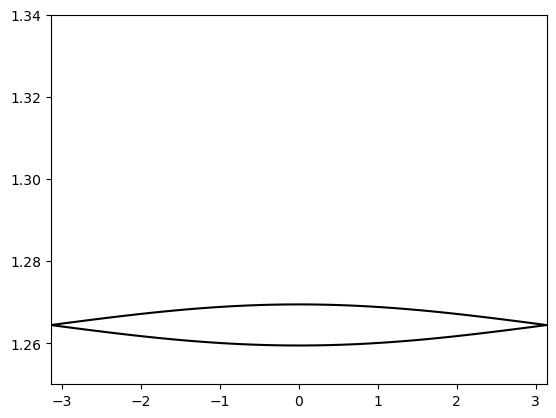

In [1134]:
thp_dom, a_dom = npy.meshgrid(npy.linspace(-npy.pi,npy.pi,1000),npy.linspace(1.25,1.34,1000))
plt.clf()
cs = plt.contour(thp_dom,a_dom,H_p_a_th_sel_func(thp_dom,a_dom),levels=[H_p_sep_val_sel],colors="k")
#cs = plt.pcolormesh(thp_dom,a_dom,H_p_a_th_sel_func(thp_dom,a_dom))
#plt.colorbar(cs)
#cs = plt.contour(th_dom,a_dom,H_a_th_sel_func(th_dom,a_dom),levels=[H_sep_val_sel],colors="r")
#plt.clabel(cs, inline=True, fmt="%0.3e")
#cs = plt.pcolormesh(th_dom,a_dom,H_p_a_th_sel_func(thp_dom,a_dom))
#plt.colorbar(cs)
plt.show()

Below is at ep=0.02. 

In [1135]:
top = 1.316894
bottom = 1.3146949

In [1136]:
f"{top**(-2./3) - bottom**(-2./3):0.2e}"

'-9.28e-04'

# Separatrix for a grid of initial values (as in FLI plots)

I think I realized in general I maybe should just do a constant k. It becomes a little cumbersome with constant a & e, because $k>k_{sep}$ in in places (and there is no separatrix) not to mention the fact that defining a separatrix kind of requires a constant $k$.

This should be a relatively straightforward thing to do, and then I can do the FLI plots and choose e as a function of k=const and a on param space.

In [1137]:
np_sel = 1
ap_sel = np_sel**(-2./3)
nc_sel = (params[j]*np_sel + params[om])/(params[j]+1)
ac_sel = nc_sel**(-2./3)
pomp_sel = 0

In [1138]:
_e_func_ak = lambdify([a,k],solve(Eq(k_expr,k),e)[1].subs({ac:ac_sel,j:params[j]}))
def e_func_ak(_a,_k):
    if _a-ac_sel*_k-ac_sel > 0:
        return _e_func_ak(_a,_k)
    else:
        return 0.000


In [1139]:
#_ = npy.linspace(1.29,1.33,1000)
#plt.plot(_,[e_func_ak(x,k_sel) for x in _])

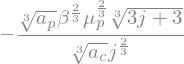

-0.00249208594081257


In [1140]:
H_simp_expr_plugin = H_simp_expr.subs(params).subs({ac:ac_sel,ap:ap_sel,np:np_sel})
display(H_simp_expr_plugin)
poly_FP_expr = H_simp_expr_plugin.diff(e)
display(poly_FP_expr)
k_sep_expr = -(
    (3 * (j + 1) * ap * b ** 2 / (j ** 2 * ac))
    ** Rational(1,3)
) * mup ** Rational(2,3)
display(k_sep_expr)
k_sep_val = k_sep_expr.subs(params).subs({ac:ac_sel,ap:ap_sel}).evalf()
print(k_sep_val)

In [1141]:
_a_expr_ek = solve(Eq(k_expr,k),a)[0]
a_func_ek = lambdify([e,k],_a_expr_ek.subs({j:params[j],ac:ac_sel}))
_a_expr_ek

In [1142]:
#k_sel = -0.006
#k_sel = -0.00249

In [1143]:
poly_FP_expr.subs(th,0)

In [1144]:
_H_func_keth = lambdify([k, e, th], H_simp_expr_plugin)
H_func_akth = lambda _a, _k, _th: _H_func_keth(k_sel, e_func_ak(_a,_k),_th)
_poly_unstFP_func_ek =  lambdify([e,k],poly_FP_expr.subs({th:0}))

In [1145]:
def H_sep_val_func(_k):
    e_search = npy.linspace(0,1,100000)
    roots = []
    _search = lambda _e: _poly_unstFP_func_ek(_e, _k)
    for i in range(len(e_search)-1):
        try:
            root = brentq(_search, e_search[i], e_search[i+1])
            roots += [root]
        except ValueError:
            pass
    return(_H_func_keth(_k,max(roots),0),max(roots))
H_sep_val_func(k_sel)

In [1146]:
#th_dom, a_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000), npy.linspace(1.3026,1.32,1000))
#th_dom, a_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000), npy.linspace(1.3075,1.33,1000))
th_dom, a_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000), npy.linspace(1.25,1.33,1000))
H_dom = npy.zeros(th_dom.shape)
for it in range(len(H_dom[:,0])):
    for jt in range(len(H_dom[0,:])):
        H_dom[it,jt] = H_func_akth(a_dom[it,jt],k_sel,th_dom[it,jt])

In [1147]:
#plt.clf()
#H_sep_val, e_sep_val = H_sep_val_func(k_sel)
#plt.contour(th_dom,a_dom,H_dom,levels=[H_sep_val])
##plt.pcolormesh(th_dom,a_dom,H_dom)
#plt.contour(th_dom,a_dom,H_p_a_th_sel_func(thp_dom,a_dom),levels=[H_p_sep_val_sel],colors="k")
#plt.plot([0,2*npy.pi],[a_func_ek(e_sep_val,k_sel),a_func_ek(e_sep_val,k_sel)])
#plt.show()

# 

# Trajectories

I don't think these count as poincaire surfaces. They're just system trajectories. Hence why I switched to discrete snapshots at perihelion of $\mu_p$ (section_t).

In [1148]:
funs = [
    iterfun.subs(convs).subs(params)
    #for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
    for iterfun in [ndot, edot, pomdot, thpdot]
]
funs
xp = [n, e, pom, thp, np, t]
funcl = lambdify(xp, funs)


def func(t, x0):
    npval = 1
    return funcl(*x0, npval, t)

def section_t(t,x0):
    return npy.cos(t)

def section(t, x0):
    #return (x0[3]+npy.pi) %2*npy.pi - npy.pi
    return npy.cos(x0[3])
    # return(npy.cos(x0[2]))
    # return(npy.cos(x0[3]))
    # return npy.cos(x0[3] + params[omp] * t)


def section1(t, x0):
    #return (x0[3] + params[omp] * t - x0[2] + npy.pi) % 2*npy.pi - npy.pi
    return npy.cos(x0[3] + params[omp] * t - x0[2])

def section2(t, x0):
    th_angle = x0[3]/(params[j]+1)
    return npy.cos(th_angle)
def section3(t, x0):
    phi_angle = npy.arctan2(x0[1]*npy.sin(params[omp]*t-x0[2]), x0[1]*npy.cos(params[omp]*t-x0[2])-npy.abs(params[bp]/params[b])*params[ep])
    return npy.cos(phi_angle)

def section4(t, x0):
    phi_angle = npy.arctan2(x0[1]*npy.sin(params[omp]*t-x0[2]), x0[1]*npy.cos(params[omp]*t-x0[2])-npy.abs(params[bp]/params[b])*params[ep])
    comb_angle = x0[3] + phi_angle 
    return npy.cos(comb_angle)


def get_sections(a0val, kval, th0val, pom0val):
    nc_sel = (params[j] * 1 + params[om]) / (params[j] + 1)
    ac_sel = nc_sel ** (-2.0 / 3)
    e_sel = npy.sqrt(a0val - ac_sel * kval - ac_sel) / npy.sqrt(
        ac_sel * (params[j] + 1)
    )
    teval = npy.linspace(0, 2 * npy.pi * T_INTEG, 10000)
    thp0val = th0val + pom0val - varpip0val

    section_t.direction = 1
    section.direction = 1
    section1.direction = 1
    section2.direction = 1
    section3.direction = 1
    section4.direction = 1

    sol = sp.integrate.solve_ivp(
        func,
        [teval[0], teval[-1]],
        [a0val ** (-3.0 / 2), e_sel, pom0val, thp0val],
        t_eval=teval,
        rtol=1e-9,
        # atol=1e-9,
        method="DOP853",
        events=[section, section1, section2, section3,section4,section_t],
    )
    d = {}

    if len(sol.y_events[0]) > 0:
        events_th0 = (sol.y_events[0][:, 3] + params[omp] * sol.t_events[0]) % (
            2 * npy.pi
        )
        events_thp = sol.y_events[0][:, 3] % (2 * npy.pi)
        events_th = (
            sol.y_events[0][:, 3]
            + params[omp] * sol.t_events[0]
            - sol.y_events[0][:, 2]
        )
        events_th = events_th % (2 * npy.pi)
        events_e = sol.y_events[0][:, 1]
        events_n = sol.y_events[0][:, 0]
        events_a = events_n ** (-2.0 / 3)
        d["thp"] = [events_a, events_th, events_thp, events_th0, events_e]
    else:
        d["thp"] = None

    if len(sol.y_events[1]) > 0:
        events1_th0 = (sol.y_events[1][:, 3] + params[omp] * sol.t_events[1]) % (
            2 * npy.pi
        )
        events1_thp = sol.y_events[1][:, 3] % (2 * npy.pi)
        events1_th = (
            sol.y_events[1][:, 3]
            + params[omp] * sol.t_events[1]
            - sol.y_events[1][:, 2]
        )
        events1_th = events1_th % (2 * npy.pi)
        events1_e = sol.y_events[1][:, 1]
        events1_n = sol.y_events[1][:, 0]
        events1_a = events1_n ** (-2.0 / 3)
        d["th"] = [events1_a, events1_th, events1_thp, events1_th0, events1_e]
    else:
        d["th"] = None

    if len(sol.y_events[2]) > 0:
        events2_th0 = (sol.y_events[2][:, 3] + params[omp] * sol.t_events[2]) % (
            2 * npy.pi
        )
        events2_thp = sol.y_events[2][:, 3] % (2 * npy.pi)
        events2_th = (
            sol.y_events[2][:, 3]
            + params[omp] * sol.t_events[2]
            - sol.y_events[2][:, 2]
        )
        events2_th = events2_th % (2 * npy.pi)
        events2_e = sol.y_events[2][:, 1]
        events2_n = sol.y_events[2][:, 0]
        events2_a = events2_n ** (-2.0 / 3)

        events2_phi = npy.arctan2(events2_e*npy.sin(params[omp]*sol.t_events[2]-sol.y_events[2][:,2]), events2_e*npy.cos(params[omp]*sol.t_events[2]-sol.y_events[2][:,2])-npy.abs(params[bp]/params[b])*params[ep])
        events2_Phi = events2_e**2/2/npy.sqrt(alpha0val) - 1/npy.sqrt(alpha0val)*npy.abs(params[bp]/params[b])*events2_e*params[ep] + params[ep]**2*params[bp]**2/2/npy.sqrt(alpha0val)/params[b]**2

        events2_thcanon = events2_thp / (params[j]+1)
        events2_Th = npy.sqrt(events2_a)
        d["th_canon"] = [events2_a, events2_th, events2_thp, events2_th0, events2_e, events2_phi, events2_Phi, events2_thcanon, events2_Th]
    else:
        d["th_canon"] = None

    if len(sol.y_events[3]) > 0:
        events3_th0 = (sol.y_events[3][:, 3] + params[omp] * sol.t_events[3]) % (
            2 * npy.pi
        )
        events3_thp = sol.y_events[3][:, 3] % (2 * npy.pi)
        events3_th = (
            sol.y_events[3][:, 3]
            + params[omp] * sol.t_events[3]
            - sol.y_events[3][:, 2]
        )
        events3_th = events3_th % (2 * npy.pi)
        events3_e = sol.y_events[3][:, 1]
        events3_n = sol.y_events[3][:, 0]
        events3_a = events3_n ** (-2.0 / 3)

        events3_phi = npy.arctan2(events3_e*npy.sin(params[omp]*sol.t_events[3]-sol.y_events[3][:,2]), events3_e*npy.cos(params[omp]*sol.t_events[3]-sol.y_events[3][:,2])-npy.abs(params[bp]/params[b])*params[ep])
        events3_Phi = events3_e**2/2/npy.sqrt(alpha0val) - 1/npy.sqrt(alpha0val)*npy.abs(params[bp]/params[b])*events3_e*params[ep] + params[ep]**2*params[bp]**2/2/npy.sqrt(alpha0val)/params[b]**2

        events3_thcanon = events3_thp / (params[j]+1)
        events3_Th = npy.sqrt(events3_a)
        d["phi_canon"] = [events3_a, events3_th, events3_thp, events3_th0, events3_e,  events3_phi, events3_Phi,events3_thcanon, events3_Th]
    else:
        d["phi_canon"] = None

    if len(sol.y_events[4]) > 0:
        events4_th0 = (sol.y_events[4][:, 3] + params[omp] * sol.t_events[4]) % (
            2 * npy.pi
        )
        events4_thp = sol.y_events[4][:, 3] % (2 * npy.pi)
        events4_th = (
            sol.y_events[4][:, 3]
            + params[omp] * sol.t_events[4]
            - sol.y_events[4][:, 2]
        )
        events4_th = events4_th % (2 * npy.pi)
        events4_e = sol.y_events[4][:, 1]
        events4_n = sol.y_events[4][:, 0]
        events4_a = events4_n ** (-2.0 / 3)

        events4_thcanon = events4_thp / (params[j]+1)
        events4_Th = npy.sqrt(events4_a)

        events4_phi = npy.arctan2(events4_e*npy.sin(params[omp]*sol.t_events[4]-sol.y_events[4][:,2]), events4_e*npy.cos(params[omp]*sol.t_events[4]-sol.y_events[4][:,2])-npy.abs(params[bp]/params[b])*params[ep])
        events4_Phi = events4_e**2/2/npy.sqrt(alpha0val) - 1/npy.sqrt(alpha0val)*npy.abs(params[bp]/params[b])*events4_e*params[ep] + params[ep]**2*params[bp]**2/2/npy.sqrt(alpha0val)/params[b]**2
        d["(j+1)th+phi"] = [events4_a, events4_th, events4_thp, events4_th0, events4_e, events4_phi, events4_Phi, events4_thcanon, events4_Th]
    else:
        d["(j+1)th+phi"] = None

    if len(sol.y_events[5]) > 0:
        events5_th0 = (sol.y_events[5][:, 3] + params[omp] * sol.t_events[5]) % (
            2 * npy.pi
        )
        events5_thp = sol.y_events[5][:, 3] % (2 * npy.pi)
        events5_th = (
            sol.y_events[5][:, 3]
            + params[omp] * sol.t_events[5]
            - sol.y_events[5][:, 2]
        )
        events5_th = events5_th % (2 * npy.pi)
        events5_e = sol.y_events[5][:, 1]
        events5_n = sol.y_events[5][:, 0]
        events5_a = events5_n ** (-2.0 / 3)

        events5_thcanon = events5_thp / (params[j]+1)
        events5_Th = npy.sqrt(events5_a)

        events5_phi = npy.arctan2(events5_e*npy.sin(params[omp]*sol.t_events[5]-sol.y_events[5][:,2]), events5_e*npy.cos(params[omp]*sol.t_events[5]-sol.y_events[5][:,2])-npy.abs(params[bp]/params[b])*params[ep])
        events5_Phi = events5_e**2/2/npy.sqrt(alpha0val) - 1/npy.sqrt(alpha0val)*npy.abs(params[bp]/params[b])*events5_e*params[ep] + params[ep]**2*params[bp]**2/2/npy.sqrt(alpha0val)/params[b]**2
        d["t_2pi"] = [events5_a, events5_th, events5_thp, events5_th0, events5_e, events5_phi, events5_Phi, events5_thcanon, events5_Th]
    else:
        d["t_2pi"] = None

    return d, sol

In [1149]:
runs = {}
sols = {}
for i in range(N_runs):
    a0val = a0vals[i]
    th0val = th0vals[i]
    print(i)
    try:
        _ = get_sections(a0val, k_sel, th0val, pom0val)
        runs[(a0val, k_sel)] = _[0]
        sols[(a0val, k_sel)] = _[1]
    except ValueError:
        pass

0
1
2
3
4
5
6
7


# Plot

In [1150]:
%matplotlib inline

In [1151]:
if params[omp] != params[om]:
    Domlatex = f"{params[omp]-params[om]:0.1e}".replace('e-0', 'e-').replace('e+0', 'e').replace("e", r" \times 10^{") + "}"
    Domlatex = Domlatex.split()[2]
else:
    Domlatex = 0
Domlatex

'10^{-1}'

8


<Figure size 640x480 with 0 Axes>

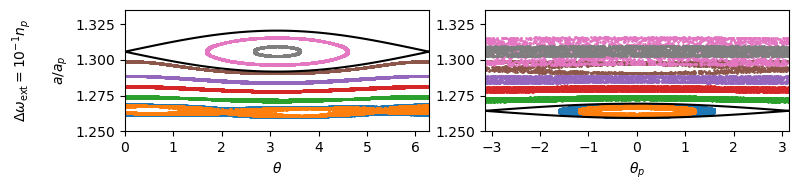

In [1152]:
#%matplotlib widget 
#%matplotlib inline
plt.clf()
plt.figure(figsize=(8,2))
print(len(runs))
H_sep_val, _ = H_sep_val_func(k_sel)
jit = 0
for a0val, kval in runs.keys():
    c = plt.rcParams['axes.prop_cycle'].by_key()['color'][jit%len(plt.rcParams['axes.prop_cycle'].by_key()['color'])]
    jit += 1
    plt.subplot(1,2,1)
    sol = sols[(a0val,kval)]
    _a = sol.y[0,:]**(-2./3)
    _thp = (sol.y[3,:]) %(2*npy.pi)
    _th = (sol.y[3,:] + sol.t*params[omp] - sol.y[2,:]) % (2*npy.pi)
    plt.scatter(_th,_a,s=1,c=c)
    #plt.text(_th[0],_a[0],jit)
    #try:
    #   plt.scatter(runs[(a0val,kval)]["t_2pi"][1],runs[(a0val,kval)]["t_2pi"][0],s=1,c=c)
    #   plt.text(runs[(a0val,kval)]["t_2pi"][1][0],runs[(a0val,kval)]["t_2pi"][0][0],jit)
    #except:
    #    pass
    plt.subplot(1,2,2)
    try:
        plt.scatter((runs[(a0val,kval)]["t_2pi"][2]+npy.pi)%(2*npy.pi)-npy.pi,runs[(a0val,kval)]["t_2pi"][0],s=1,c=c)
        #plt.scatter((runs[(a0val,kval)]["phi_canon"][2]+npy.pi)%(2*npy.pi),runs[(a0val,kval)]["phi_canon"][0],s=1)
    except:
        pass
    #plt.scatter(runs[(a0val,kval)][4]*npy.cos(runs[(a0val,kval)][1]),runs[(a0val,kval)][4]*npy.sin(runs[(a0val,kval)][1]),s=1)
plt.subplot(1,2,1)
if Domlatex != 0:
    plt.ylabel(r"$\Delta\omega_{\rm ext}="+Domlatex+"n_p$\n\n"+r"$a/a_p$")
else:
    plt.ylabel(r"$\Delta\omega_{\rm ext}=0$"+"\n\n"+r"$a/a_p$")
plt.ylim(1.25,1.335)
plt.xlabel(r"$\theta$")
plt.contour(th_dom,a_dom,H_dom,levels=[H_sep_val],colors="k")
plt.subplot(1,2,2)
plt.ylim(1.25,1.335)
plt.xlabel(r"$\theta_p$")
plt.contour(thp_dom,a_dom,H_p_a_th_sel_func(thp_dom,a_dom),levels=[H_p_sep_val_sel],colors="k")
#plt.plot([0,2*npy.pi],[a_func_ek(0,k_sel),a_func_ek(0,k_sel)],c="k",ls="--")
#plt.suptitle(r"$\omega_p=$"+f"{params[omp]:0.2e}\n"+r"$\omega=$"+f"{params[om]:0.2e}")
plt.tight_layout()
plt.savefig(r"paper 2 figures/peri phase large sep.png",dpi=300)

In [1153]:
jit = 0
for a0val, kval in runs.keys():
    jit += 1
    if jit == 15: _ = (a0val,kval)
print(_)
sol = sols[_]
plt.clf()
_a = sol.y[0, :] ** (-2.0 / 3)
_thp = sol.y[3, :] % (2*npy.pi)
_th = (_thp + params[omp] * sol.t - sol.y[2, :])% (2*npy.pi)
plt.scatter( _th,_a, s=0.1)
plt.show()

0.18243648790080594


KeyError: 0.18243648790080594

20


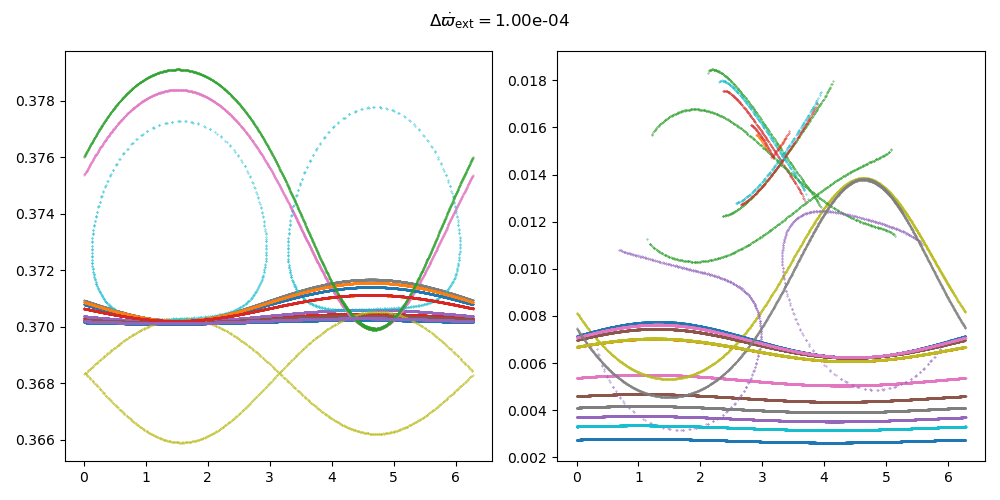

In [ ]:
#d["th"] = [events1_a, events1_th, events1_thp, events1_th0, events1_e]
%matplotlib widget 
#%matplotlib inline
plt.clf()
plt.figure(figsize=(10,5))
print(len(runs))
H_sep_val, _ = H_sep_val_func(k_sel)
jit = 0

plt.suptitle(r"$\Delta\dot\varpi_{\rm ext}=$"+f"{params[omp]-params[om]:0.2e}")
for a0val, kval in runs.keys():
    c = plt.rcParams['axes.prop_cycle'].by_key()['color'][jit%len(plt.rcParams['axes.prop_cycle'].by_key()['color'])]
    jit += 1
    #if jit > 3: break
    event = runs[(a0val,kval)]["th"]
    try:
        plt.subplot(1,2,1)
        _Lam = npy.sqrt(event[0])
        _Gam = 0.5*_Lam*event[4]**2
        j1angle = event[2]
        J1 = _Lam/(params[j]+1)-_Gam
        X = j1angle
        Y = J1
        plt.scatter(X,Y,s=0.1)
    except:
        pass
    event = runs[(a0val,kval)]["thp"]
    try:
        plt.subplot(1,2,2)
        _Lam = npy.sqrt(event[0])
        _Gam = 0.5*_Lam*event[4]**2
        j2angle = event[1]
        J2 = _Gam
        X = j2angle
        Y = J2
        plt.scatter(X,Y,s=0.1)
    except:
        pass
plt.tight_layout()

20


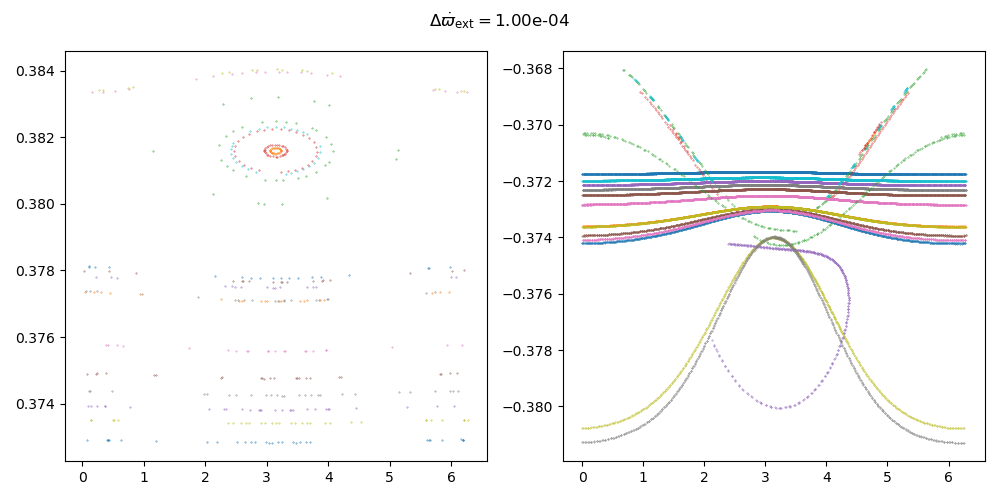

In [ ]:
%matplotlib widget 
#%matplotlib inline
plt.clf()
plt.figure(figsize=(10,5))
print(len(runs))
H_sep_val, _ = H_sep_val_func(k_sel)
jit = 0

plt.suptitle(r"$\Delta\dot\varpi_{\rm ext}=$"+f"{params[omp]-params[om]:0.2e}")
for a0val, kval in runs.keys():
    c = plt.rcParams['axes.prop_cycle'].by_key()['color'][jit%len(plt.rcParams['axes.prop_cycle'].by_key()['color'])]
    jit += 1
    #if jit > 3: break
    event = runs[(a0val,kval)]["phi_canon"]
    try:
        plt.subplot(1,2,1)
        phiangle = event[5]
        Phicanon = event[6]
        thcanonangle = event[7]
        Thcanon = event[8]
        j1angle = ((params[j]+1)*thcanonangle + phiangle)%(2*npy.pi)
        j2angle = (phiangle)%(2*npy.pi)
        J1 = Thcanon/(params[j]+1)
        J2 = Phicanon - Thcanon/(params[j]+1)
        X = j1angle
        Y = J1
        plt.scatter(X,Y,s=0.1)
    except:
        pass
    event = runs[(a0val,kval)]["th_canon"]
    try:
        plt.subplot(1,2,2)
        phiangle = event[5]
        Phicanon = event[6]
        thcanonangle = event[7]
        Thcanon = event[8]
        j1angle = ((params[j]+1)*thcanonangle + phiangle)%(2*npy.pi)
        j2angle = (phiangle)%(2*npy.pi)
        J1 = Thcanon/(params[j]+1)
        J2 = Phicanon - Thcanon/(params[j]+1)
        X = j2angle
        Y = J2
        plt.scatter(X,Y,s=0.1)
    except:
        pass
plt.tight_layout()